<a href="https://colab.research.google.com/github/OseiasBeu/fight_project/blob/main/Baseline_models_paralelo_UFC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Desbilitando GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Processamneto / validação
from imblearn.over_sampling import ADASYN # over-sampling
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Modelos
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Metricas
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Constantes para replicabilidade
#SEED = 111
#os.environ['PYTHONHASHSEED'] = str(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)

# cpu worker
WORKERS = 4

In [35]:
df = pd.read_csv("https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/UFC_TRAIN.csv")
X = df.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values

# over-sampling
over_sampler = ADASYN()
X, y = over_sampler.fit_resample(X, y)

pd.Series(y).value_counts()

0    2985
1    2910
dtype: int64

# Validação k-Fold estratificada com uma variedade de modelos

   Acurácia Média  CrossValerrors         Algoritmo
1        0.800779        0.120230        ExtraTrees
0        0.762143        0.167922                RF
2        0.750611        0.172182  GradientBoosting
4        0.617127        0.026177               LDA
3        0.615438        0.023842            LogReg


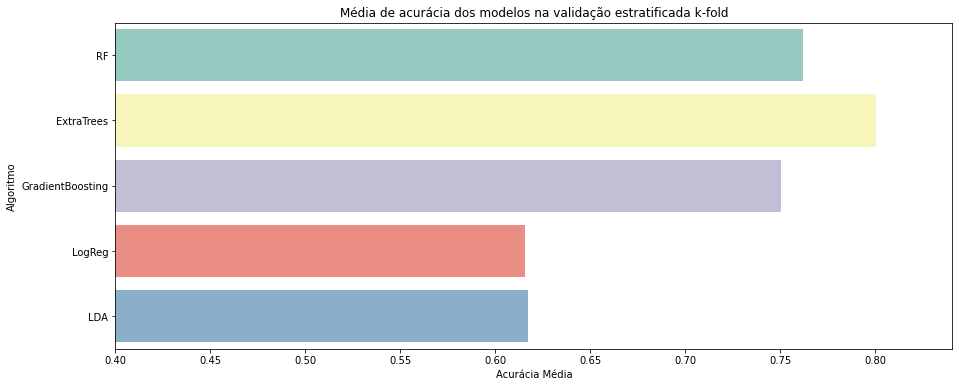

In [36]:
classifiers = [
    
    #SVC(random_state=SEED),
    #DecisionTreeClassifier(random_state=SEED),
    #AdaBoostClassifier(DecisionTreeClassifier(random_state=SEED),random_state=SEED,learning_rate=0.1),
    #RandomForestClassifier(random_state=SEED),
    #ExtraTreesClassifier(random_state=SEED),
    #GradientBoostingClassifier(random_state=SEED),
    #MLPClassifier(random_state=SEED),
    #KNeighborsClassifier(),
    #LogisticRegression(random_state = SEED),
    #LinearDiscriminantAnalysis()
    

    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    LinearDiscriminantAnalysis()
]
#classifiers.append(XGBClassifier(n_estimators=200)) # we can append models 

kfold = StratifiedKFold( n_splits=10 ) # k = 10 stratified folds
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X=X, y = y, scoring = "accuracy", cv = kfold, n_jobs=WORKERS))

# Precisão média e padrão de cada modelo (forma: número de modelos)
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"Acurácia Média":cv_means,
                       "CrossValerrors": cv_std,
                       "Algoritmo":
                       [
                           #"SVM",
                           #"DT",
                           #"AdaBoost",
                           "RF",
                           "ExtraTrees",
                           "GradientBoosting",
                           #"MLP",
                           #"KNN",
                           "LogReg",
                           "LDA",
                           #"XGB"
                       ]
                      }
                     )
print(cv_res.sort_values("Acurácia Média", ascending=False))
plt.figure(figsize=(15,6))
g = sns.barplot(x="Acurácia Média",y="Algoritmo",data = cv_res, palette="Set3",orient = "h")
g.set(xlim=(0.4))
g.set_xlabel("Acurácia Média")
g = g.set_title("Média de acurácia dos modelos na validação estratificada k-fold")


# Seleção de modelo:

LDA, GradientBoosting e LogReg são escolhidos para estarem no modelo Ensemble

In [37]:
ldaClf = LinearDiscriminantAnalysis()
ldaClf = ldaClf.fit(X,y)

#gboostClf = GradientBoostingClassifier(random_state=SEED)
gboostClf = GradientBoostingClassifier()
gboostClf = gboostClf.fit(X,y)

#lrClf = LogisticRegression(random_state = SEED,n_jobs=WORKERS)
lrClf = LogisticRegression(n_jobs=WORKERS)
lrClf = lrClf.fit(X,y)

#exTreeClf = ExtraTreesClassifier(random_state=SEED)
exTreeClf = ExtraTreesClassifier()
exTreeClf = exTreeClf.fit(X,y)

#rfClf = RandomForestClassifier(random_state=SEED)
rfClf = RandomForestClassifier()
rfClf = rfClf.fit(X,y)


# Método de conjuntos:

In [38]:
ensClf = VotingClassifier(estimators=
                          [
                              ('ldaClf', ldaClf),
                              ('gboostClf', gboostClf),
                              ('lrClf', lrClf),
                              ('exTreeClf', exTreeClf),
                              ('rfClf', rfClf),
                              #('xgbClf', xgbClf)
                          ],
                          voting='soft', n_jobs=WORKERS)
ensClf = ensClf.fit(X, y)
print(f"{len([e[0] for e in ensClf.estimators])} Modelos no conjunto: {[e[0] for e in ensClf.estimators]}")

5 Modelos no conjunto: ['ldaClf', 'gboostClf', 'lrClf', 'exTreeClf', 'rfClf']


# Avaliação de desempenho no dataset de teste:

In [39]:
TEST = pd.read_csv("https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/UFC_TEST.csv")
X_TEST = TEST.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
y_TEST = TEST["Winner"].values
target_names = ['class 0', 'class 1']
ensPreds_TEST = ensClf.predict(X_TEST)
print("Ensemble TEST Performance on BALANCED:\n------------------\n",classification_report(y_TEST, ensPreds_TEST , target_names=target_names))
print("AUC: ",roc_auc_score(y_TEST, ensPreds_TEST))


Ensemble TEST Performance on BALANCED:
------------------
               precision    recall  f1-score   support

     class 0       0.75      0.82      0.78       157
     class 1       0.53      0.41      0.46        75

    accuracy                           0.69       232
   macro avg       0.64      0.62      0.62       232
weighted avg       0.67      0.69      0.68       232

AUC:  0.6174946921443737


# Salvando modelo

In [40]:
import pickle
pickle.dump(ensClf, open('ens_method.sav', 'wb'))

In [ ]:
from google.colab import files
files.download('/content/ens_method.sav')